#**Background**

During the pandemic there has been a shift in behaviour; industry has been disrupted and people are working from home. The purpose of this challenge is to examine historical electricity consumption data to determine if such shifts can be detected in the data.

Thus can it be a good barometer for activity that can function as a good additional metric input to traditional models for better decision making in unprecedented conditions. 

## Key Drivers

There are a few key drivers that determine the amount of electricity consumed at any point in time:

1) **the weather** (temp) – we use electric heating and cooling (unaffected post covid)

2) **seasonality** (solar) – we use electric lighting (unaffected post covid)

3) **business cycles** (DoWk) – there is considerably less consumption at weekends, on public holidays and during school holidays

4) **base load** (traffic_data) – the underlying population size and level of business activity (ie growth/contraction)

#**Data Preperation**

Cleaning the Data, Formating and Transformations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime
from IPython.display import display

import os
import glob
# Set the styles to Seaborn


### Elec Data Collection

Electricity consumption data for victoria over the past 4 years were downloaded from AECOM in csv file formart with one file for each month.

In [2]:
path = "drive/MyDrive/Colab_Notebooks/elec_data"
os.chdir(path)

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_elec_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

#Return to home dir
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [3]:
#CSV files combined into one pandas data frame
combined_elec_csv

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,VIC1,2020/01/01 00:30:00,4185.32,64.76,TRADE
1,VIC1,2020/01/01 01:00:00,4057.68,63.36,TRADE
2,VIC1,2020/01/01 01:30:00,3954.85,65.21,TRADE
3,VIC1,2020/01/01 02:00:00,3792.25,64.45,TRADE
4,VIC1,2020/01/01 02:30:00,3689.33,63.23,TRADE
...,...,...,...,...,...
1483,VIC1,2017/12/31 22:00:00,4180.03,92.98,TRADE
1484,VIC1,2017/12/31 22:30:00,4152.28,99.46,TRADE
1485,VIC1,2017/12/31 23:00:00,4173.92,97.20,TRADE
1486,VIC1,2017/12/31 23:30:00,4419.10,88.16,TRADE


### Elec Data Cleaning

 Electricity Consumption is the Target Data. Eliminate columns that are not useful e.g. Region and Periodtype

In [4]:
# Import combined monthly data
elec_data = combined_elec_csv.copy()

# Order data by date
elec_data = elec_data.sort_values(by='SETTLEMENTDATE')

# Drop unecessary columns and rows to make data uniform
elec_data = elec_data.drop(['REGION','PERIODTYPE'],axis=1)
elec_data.reset_index(drop=True, inplace=True)
elec_data = elec_data.iloc[:-1]


### Checkpoint

In [5]:
elec_data.head() #check

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2017/01/01 00:30:00,4097.58,15.94
1,2017/01/01 01:00:00,4034.74,20.16
2,2017/01/01 01:30:00,3851.70,20.78
3,2017/01/01 02:00:00,3649.99,22.23
4,2017/01/01 02:30:00,3517.65,24.23


In [6]:
#DISPLAY DATAFRAMES AS INTERACTIVE TABLES
#%load_ext google.colab.data_table
#%unload_ext google.colab.data_table


### Add Daily Temp Min & Max Data

In [7]:
#Daily Temperature
t_min_raw = pd.read_csv("temp_min.csv")
t_min_raw = t_min_raw.drop(2846)
t_max_raw = pd.read_csv("temp_max.csv")

## Formart Date
temp = pd.DataFrame()
temp["Date"] = pd.to_datetime(
                              t_max_raw.Year*10000
                              +t_max_raw.Month*100
                              +t_max_raw.Day,format='%Y%m%d'
                              )

# temp min/max csv formatting
temp = pd.DataFrame()
temp["Date"] = pd.to_datetime(t_max_raw.Year*10000+t_max_raw.Month*100+t_max_raw.Day,format='%Y%m%d')
temp = temp.join(t_max_raw["Maximum temperature (Degree C)"])
temp = temp.join(t_min_raw["Minimum temperature (Degree C)"])
temp = temp[temp["Date"] > "2016-12-31"]
temp.reset_index(drop=True, inplace=True)

### Add Solar Exposure Data


The data set was downloaded from [data.gov.au-solar_expousre](https://data.gov.au/dataset/ds-bom-ANZCW0503900376a/details?q=)

In [8]:
## Import and formart solar data
solar_raw = pd.read_csv("solar_exposure.csv")
solar_data = solar_raw.copy()
solar_data = solar_data[solar_data["Year"] > 2016]
solar_data.reset_index(drop=True, inplace=True)

Combine the weather data together

In [9]:
## add solar data
temp = temp.join(solar_data["Daily global solar exposure (MJ/m*m)"])

### Checkpoint

In [10]:
temp.head()

,Date,Maximum temperature (Degree C),Minimum temperature (Degree C),Daily global solar exposure (MJ/m*m)
0,2017-01-01,21.1,16.8,8.5
1,2017-01-02,17.8,14.8,7.8
2,2017-01-03,19.5,14.6,25.9
3,2017-01-04,29.3,13.3,31.6
4,2017-01-05,31.7,18.5,29.7


### Add VIC Public Holiday Data

The data set was downloaded from [data.gov.au-public-holidays](https://data.gov.au/dataset/ds-dga-b1bc6077-dadd-4f61-9f8c-002ab2cdff10/details)

In [11]:
##Format Holiday data from 2017-2020
df_20 = pd.read_csv("vic_holidays/australian_public_holidays_2020.csv")[["Date", "Holiday Name","Jurisdiction"]]
df_19 = pd.read_csv("vic_holidays/australian_public_holidays_2019.csv")[["Date", "Holiday Name","Jurisdiction"]]
df_1817 = pd.read_csv("vic_holidays/australianpublicholidays-201718.csv")[["Date", "Holiday Name","Applicable To"]]
df_1817 = df_1817.rename(columns={"Applicable To":"Jurisdiction"})
vic_holidays = df_20.append(df_19)
vic_holidays = vic_holidays.append(df_1817)

##Combine both national and state level holidays
nat_holidays = vic_holidays[vic_holidays['Jurisdiction'].str.contains("NAT", case=False)] #get Nat holidays
vic_holidays = vic_holidays[vic_holidays['Jurisdiction'].str.contains("VIC", case=False)]

vic_holidays = vic_holidays.append(nat_holidays)
vic_holidays = vic_holidays.sort_values(by="Date")

##Format Date
vic_holidays['Date'] = pd.to_datetime(vic_holidays['Date'],format='%Y%m%d')
vic_holidays.set_index('Date', inplace=True)
temp.set_index('Date', inplace=True)
temp["Holiday Name"] = "None"

In [12]:
temp.update(vic_holidays["Holiday Name"])
temp = temp.reset_index()
temp.head()

,Date,Maximum temperature (Degree C),Minimum temperature (Degree C),Daily global solar exposure (MJ/m*m),Holiday Name
0,2017-01-01,21.1,16.8,8.5,New Year's Day
1,2017-01-02,17.8,14.8,7.8,Additional day
2,2017-01-03,19.5,14.6,25.9,None
3,2017-01-04,29.3,13.3,31.6,None
4,2017-01-05,31.7,18.5,29.7,None


Elec consumption was recorded in 30 minute time frames where's temperature was recorded only once daily hence the need for interpolation.


In [13]:
temp = temp.loc[temp.index.repeat(48)]
temp = temp.iloc[1:]
temp.append(temp.iloc[-1])
temp.reset_index(drop=True, inplace=True)

In [14]:
## Check Formatting is correct
all_data = temp.copy()
all_data.tail()

,Date,Maximum temperature (Degree C),Minimum temperature (Degree C),Daily global solar exposure (MJ/m*m),Holiday Name
66474,2020-10-16,18.2,9.4,18.2,None
66475,2020-10-16,18.2,9.4,18.2,None
66476,2020-10-16,18.2,9.4,18.2,None
66477,2020-10-16,18.2,9.4,18.2,None
66478,2020-10-16,18.2,9.4,18.2,None


### Merge all Time Series Data

Combine Target Data (Elec-Consumption) with other time series data 

In [15]:
all_data["datetime"] = pd.to_datetime(elec_data["SETTLEMENTDATE"])
all_data[["consumption_MW", "retail_price"]] = elec_data[["TOTALDEMAND", "RRP"]]

Format column names and datetime index

In [16]:
# Add Day of the week and datetime
all_data.insert(0, "day_of_week", all_data["datetime"].dt.day_name())
# set dates as index
all_data.set_index('datetime', inplace=True)
all_data = all_data.drop("Date", axis=1)
#Formart Datetime and column names
all_data = all_data.rename(columns={"Maximum temperature (Degree C)": "max_temp",
                                    "Minimum temperature (Degree C)": "min_temp",
                                    "Daily global solar exposure (MJ/m*m)":"solar_exposure",
                                    "Holiday Name":"holiday"})

### Checkpoint

In [17]:
## Check Formatting is correct
all_data.head()

,day_of_week,max_temp,min_temp,solar_exposure,holiday,consumption_MW,retail_price
datetime,,,,,,,
2017-01-01 00:30:00,Sunday,21.1,16.8,8.5,New Year's Day,4097.58,15.94
2017-01-01 01:00:00,Sunday,21.1,16.8,8.5,New Year's Day,4034.74,20.16
2017-01-01 01:30:00,Sunday,21.1,16.8,8.5,New Year's Day,3851.70,20.78
2017-01-01 02:00:00,Sunday,21.1,16.8,8.5,New Year's Day,3649.99,22.23
2017-01-01 02:30:00,Sunday,21.1,16.8,8.5,New Year's Day,3517.65,24.23


## Drop Missing Values

In [18]:
## Eyeball for Null values
## all_data[all_data.isnull().any(axis=1)]

In [19]:
all_data = all_data.fillna(method="bfill")
all_data.isnull().sum()

day_of_week       0
max_temp          0
min_temp          0
solar_exposure    0
holiday           0
consumption_MW    0
retail_price      0
dtype: int64

In [20]:
## Check no nulls left
all_data.describe(include="all")

,day_of_week,max_temp,min_temp,solar_exposure,holiday,consumption_MW,retail_price
count,66479,66479.000000,66479.000000,66479.000000,66479,66479.000000,66479.000000
unique,7,NaN,NaN,NaN,19,NaN,NaN
top,Friday,NaN,NaN,NaN,None,NaN,NaN
freq,9504,NaN,NaN,NaN,64128,NaN,NaN
mean,NaN,20.443311,11.487646,14.622764,NaN,4925.389584,88.652443
std,NaN,6.278129,4.404234,7.782932,NaN,869.961599,277.264666
min,NaN,9.000000,0.800000,0.700000,NaN,2712.530000,-554.620000
25%,NaN,15.500000,8.300000,8.300000,NaN,4267.980000,52.940000
50%,NaN,19.200000,11.200000,12.600000,NaN,4837.790000,78.490000
75%,NaN,23.900000,14.500000,20.200000,NaN,5443.890000,102.700000


# **Exploratory Data Analysis**

A great step in the data exploration is to display the probability distribution function (PDF) of a variable.The PDF will show us how that variable is distributed. This makes it very easy to spot anomalies, such as outliers. The PDF is often the basis on which we decide whether we want to transform a feature.​

Through histogram distributions, we can see the location, spread and skewness of the data; it also helps to visualize whether the distribution is symmetric or skewed left or right. In addition, if it is unimodal, bimodal or multimodal. It can also show any outliers or gaps in the data.

### Elec Retail Price PDF

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


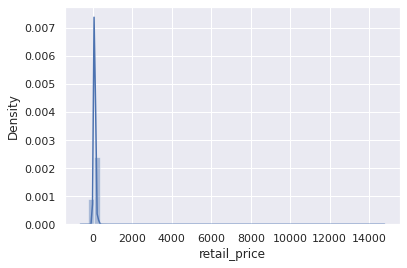

In [21]:
sns.distplot(all_data["retail_price"])

Extreme outliers shown above may becoming from extreme summer heatwave in January coupled with Australia Day a National public holiday between 4pm - 6pm

In [22]:
all_data[all_data["retail_price"] > 13000].head()

,day_of_week,max_temp,min_temp,solar_exposure,holiday,consumption_MW,retail_price
datetime,,,,,,,
2019-01-24 16:00:00,Thursday,40.8,17.3,30.0,None,8807.28,14033.16
2019-01-24 16:30:00,Thursday,40.8,17.3,30.0,None,8998.61,14496.63
2019-01-24 17:00:00,Thursday,40.8,17.3,30.0,None,9158.59,13702.21
2019-01-24 17:30:00,Thursday,40.8,17.3,30.0,None,9186.73,13998.86
2019-01-24 18:00:00,Thursday,40.8,17.3,30.0,None,9281.15,14394.66


In [23]:
all_data[all_data["retail_price"] < -300].head()

,day_of_week,max_temp,min_temp,solar_exposure,holiday,consumption_MW,retail_price
datetime,,,,,,,
2017-02-12 02:30:00,Sunday,19.9,15.1,12.6,None,3481.81,-319.03
2017-11-12 06:00:00,Sunday,23.3,13.2,25.0,None,3112.09,-342.22
2018-09-15 02:00:00,Saturday,13.7,10.2,6.3,None,3836.43,-554.62
2018-09-15 03:00:00,Saturday,13.7,10.2,6.3,None,3605.92,-387.56
2020-01-20 13:30:00,Monday,21.8,19.1,8.8,None,5226.14,-304.15


Let's declare a variable that will be equal to the 99th percentile and 1st percentile of the 'Price' variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


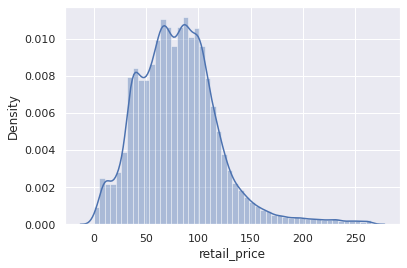

In [24]:
q_low = all_data["retail_price"].quantile(0.01)
q_high = all_data["retail_price"].quantile(0.99)

all_data_1 = all_data[all_data["retail_price"] < q_high]
all_data_1 = all_data_1[all_data_1["retail_price"] > q_low]

sns.distplot(all_data_1["retail_price"])

### Total Elec Consumption PDF

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


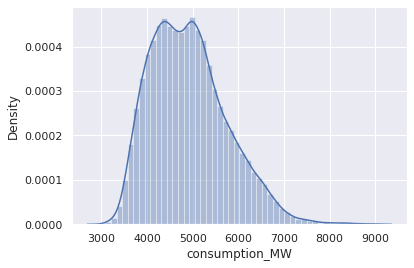

In [25]:
sns.distplot(all_data_1["consumption_MW"])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


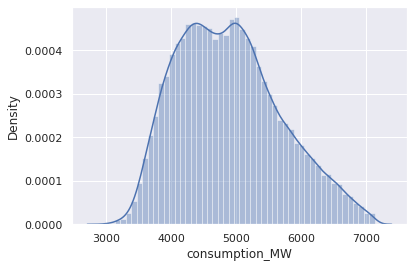

In [26]:
### Drop data outside the 99th percentile
q1 = all_data_1["consumption_MW"].quantile(0.99)
all_data_2 = all_data_1[all_data_1["consumption_MW"] < q1]
sns.distplot(all_data_2["consumption_MW"])

### Solar Exposure PDF

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


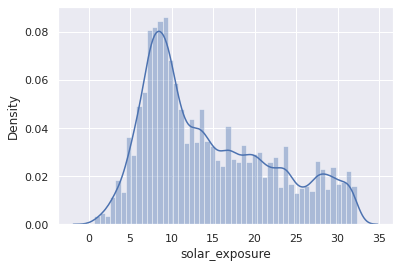

In [27]:
sns.distplot(all_data_2["solar_exposure"])

### Checkpoint

In [28]:
all_data_2.describe(include="all")

,day_of_week,max_temp,min_temp,solar_exposure,holiday,consumption_MW,retail_price
count,64483,64483.000000,64483.000000,64483.000000,64483,64483.000000,64483.000000
unique,7,NaN,NaN,NaN,19,NaN,NaN
top,Sunday,NaN,NaN,NaN,None,NaN,NaN
freq,9260,NaN,NaN,NaN,62189,NaN,NaN
mean,NaN,20.285084,11.417341,14.532928,NaN,4890.481414,80.048709
std,NaN,6.057904,4.336585,7.738742,NaN,797.000508,38.499134
min,NaN,9.000000,0.800000,0.700000,NaN,2967.210000,0.010000
25%,NaN,15.500000,8.300000,8.300000,NaN,4271.195000,53.300000
50%,NaN,19.000000,11.100000,12.400000,NaN,4827.150000,78.000000
75%,NaN,23.700000,14.400000,20.000000,NaN,5408.315000,101.700000


In [29]:
# Save data to csv file#
all_data_2.to_csv("cleaned_time_series_data.csv")

## Further Preprocessing 

### Encoding Categorical Data

In [30]:
#Dummy Variables - One Hot encoding for categorical data holidays
data_with_dummies = pd.get_dummies(all_data_2, drop_first=False)
data_with_dummies.head()

,max_temp,min_temp,solar_exposure,consumption_MW,retail_price,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_AFL Grand Final,holiday_ANZAC Day,holiday_Additional day,holiday_Anzac Day,holiday_Australia Day,holiday_Boxing Day,holiday_Christmas Day,holiday_Easter Monday,holiday_Easter Saturday,holiday_Easter Sunday,holiday_Friday before AFL Grand Final,holiday_Friday before the AFL Grand Final,holiday_Good Friday,holiday_Labour Day,holiday_Melbourne Cup,holiday_New Year's Day,holiday_None,holiday_Queen's Birthday,holiday_Saturday before Easter Sunday
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:30:00,21.1,16.8,8.5,4097.58,15.94,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-01 01:00:00,21.1,16.8,8.5,4034.74,20.16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-01 01:30:00,21.1,16.8,8.5,3851.70,20.78,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-01 02:00:00,21.1,16.8,8.5,3649.99,22.23,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-01 02:30:00,21.1,16.8,8.5,3517.65,24.23,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Split into Targets and Input Variables

In [31]:
targets = data_with_dummies[["consumption_MW"]]
inputs = data_with_dummies.drop(["consumption_MW"], axis=1)
inputs.describe(include="all")

,max_temp,min_temp,solar_exposure,retail_price,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_AFL Grand Final,holiday_ANZAC Day,holiday_Additional day,holiday_Anzac Day,holiday_Australia Day,holiday_Boxing Day,holiday_Christmas Day,holiday_Easter Monday,holiday_Easter Saturday,holiday_Easter Sunday,holiday_Friday before AFL Grand Final,holiday_Friday before the AFL Grand Final,holiday_Good Friday,holiday_Labour Day,holiday_Melbourne Cup,holiday_New Year's Day,holiday_None,holiday_Queen's Birthday,holiday_Saturday before Easter Sunday
count,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.00000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000,64483.000000
mean,20.285084,11.417341,14.532928,80.048709,0.142673,0.143526,0.142658,0.143604,0.141650,0.143170,0.14272,0.000744,0.001489,0.000744,0.001318,0.002869,0.002233,0.002233,0.002962,0.001489,0.002962,0.000667,0.000744,0.002947,0.002915,0.002156,0.002962,0.964425,0.002915,0.001225
std,6.057904,4.336585,7.738742,38.499134,0.349742,0.350611,0.349726,0.350690,0.348693,0.350248,0.34979,0.027273,0.038556,0.027273,0.036283,0.053486,0.047204,0.047204,0.054344,0.038556,0.054344,0.025815,0.027273,0.054202,0.053917,0.046379,0.054344,0.185230,0.053917,0.034981
min,9.000000,0.800000,0.700000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.500000,8.300000,8.300000,53.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,19.000000,11.100000,12.400000,78.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,23.700000,14.400000,20.000000,101.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,43.500000,28.000000,32.300000,265.310000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalize Inputs
Normalize inputs for better NN performance

In [32]:
# Import the scaling module
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(inputs)

# transform input data
inputs_norm = norm.transform(inputs)
inputs_norm = pd.DataFrame(inputs_norm, columns=inputs.columns, index=inputs.index)

In [33]:
inputs_norm.head() #check

,max_temp,min_temp,solar_exposure,retail_price,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_AFL Grand Final,holiday_ANZAC Day,holiday_Additional day,holiday_Anzac Day,holiday_Australia Day,holiday_Boxing Day,holiday_Christmas Day,holiday_Easter Monday,holiday_Easter Saturday,holiday_Easter Sunday,holiday_Friday before AFL Grand Final,holiday_Friday before the AFL Grand Final,holiday_Good Friday,holiday_Labour Day,holiday_Melbourne Cup,holiday_New Year's Day,holiday_None,holiday_Queen's Birthday,holiday_Saturday before Easter Sunday
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:30:00,0.350725,0.588235,0.246835,0.060045,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-01 01:00:00,0.350725,0.588235,0.246835,0.075952,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-01 01:30:00,0.350725,0.588235,0.246835,0.078289,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-01 02:00:00,0.350725,0.588235,0.246835,0.083754,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-01 02:30:00,0.350725,0.588235,0.246835,0.091293,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Exploring Multivariate Time Series Data

The following observations were made during the analysis:

* Strong seasonality and a very slight linear trend upwards is visible in the electrical consumption data. 
* The seasonal time series such as weather as well as the retail_price both appear to show contemporaneous correlation to the target time series. 
* Retail_price (Recommended Retail Price of Electricity spikes the most during the peak hot days of summer with the largest spike being seen on Australia day but not on Christmas or other holidays. 
* This suggest weather temperature appears to be the dominant factor when it comes to influencing outlier Electrical power consumption rather than holiday.

### Line Plots

Overlayed Moving Averages and Daily Charts 

In [34]:
### Downsample 30 minute interval consumption to daily frequency
df_daily = all_data_2.resample('D').median()
df_daily["retail_price"] = all_data_2[["retail_price"]].resample('D').mean()
df_daily["consumption_MW"] = all_data_2[["consumption_MW"]].resample('D').sum()

### Get average weekly consumption
df_weekly_mean=df_daily[["consumption_MW"]].resample('W').mean()

### 7 Day Moving Average
cols = ['consumption_MW', 'max_temp', 'min_temp', 'solar_exposure']
df_rolling_mean = df_daily[cols].rolling(7, center=True).mean()


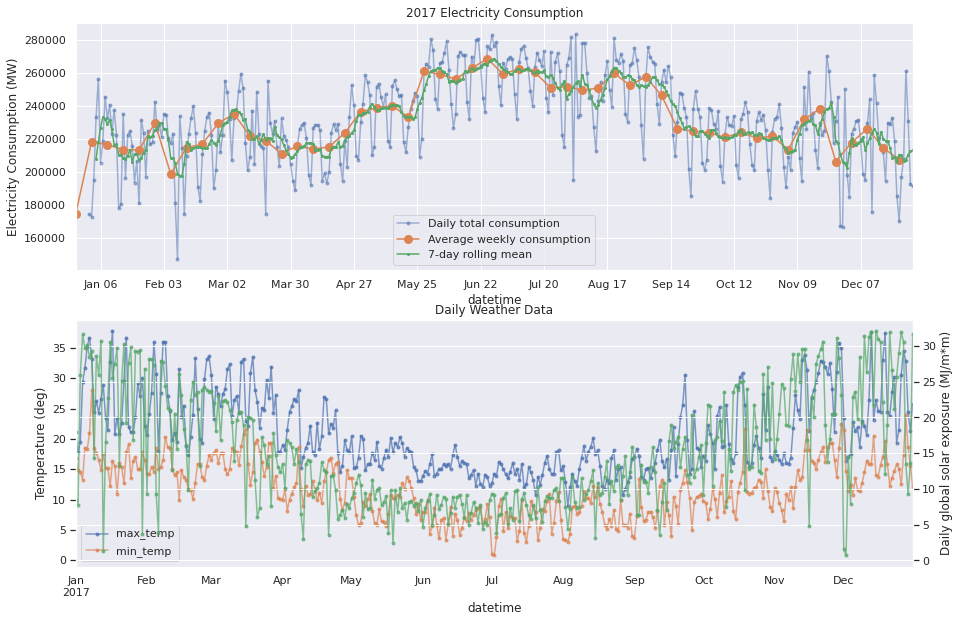

In [35]:
import matplotlib.dates as mdates

# Figure display settings
sns.set(rc={'figure.figsize':(15, 10)})
labels = ["Daily total consumption",'Average weekly consumption', 'daily max temp', 'daily min temp']

fig, (ax1, ax2) = plt.subplots(2, 1)

# Start and end of the date range to extract
start, end = '2017-01', '2017-12'

# Daily Total consumption
df_daily.loc[start:end, cols[0]].plot(ax=ax1, marker='.', alpha=0.5, linestyle='-', label=labels[0], subplots=False)

# Weekly Average consumption
df_weekly_mean.loc[start:end, cols[0]].plot(ax=ax1, marker='o', markersize=8, 
                                                     linestyle='-', label=labels[1])
# 7 Day Rolling Mean
df_rolling_mean.loc[start:end, cols[0]].plot(ax=ax1, marker='.', markersize=4, 
                                                     linestyle='-', label="7-day rolling mean")

#Daily Temp Max & Min
df_daily.loc[start:end, cols[1:]].plot(ax=ax2, secondary_y=cols[-1], marker=".", alpha=0.7,
                                       linestyle='-', subplots=False)

    
### Label and Formart Axis##
ax1.set_ylabel("Electricity Consumption (MW)")
ax1.set_title('2017 Electricity Consumption')
ax1.legend();

ax2.set_title('Daily Weather Data')
ax2.set_ylabel("Temperature (deg)")
ax2.right_ax.set_ylabel('Daily global solar exposure (MJ/m*m)')
ax2.legend();

# Set x-axis major ticks to weekly intervals starting from Mondays
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=4))
# Format x-tick labels to be month name and day number
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

### Pair Plot

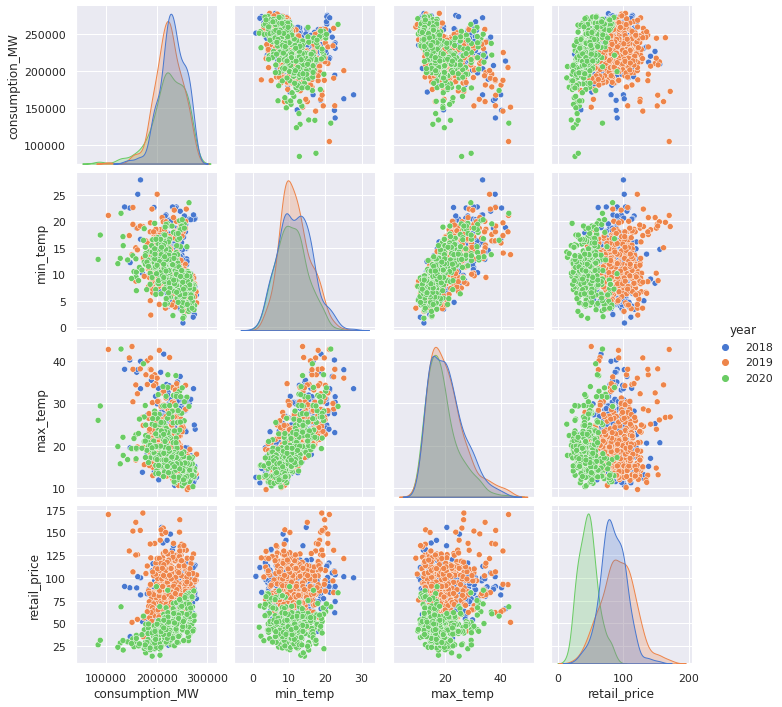

In [36]:
df = df_daily.copy()
df['year'] = df.index.year
df['month'] = df.index.month_name()
df['day'] = df.index.day_name()
sns.pairplot( df["2018":],
              hue="year", 
              vars=["consumption_MW", "min_temp","max_temp","retail_price"],
              aspect=1,
              palette="muted",
              corner=False)

### Scatter Plots

Observations:
* the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
* However the points do not cluster tightly to the diagonal line suggesting a weak correlation.
* Highest Electrical consumption is shown clustered during the colder temperatures and abit more during the occasional high temperatures

Text(0.5, 0, 'max_temp')

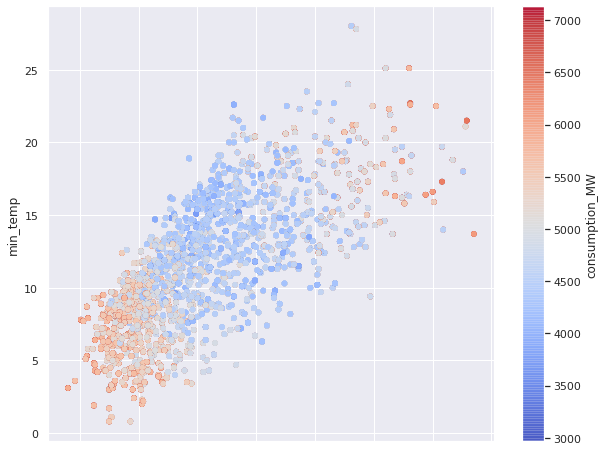

In [38]:
##  Scatter plot
ax3 = all_data_2.plot.scatter(x='max_temp',
                        y='min_temp',
                        c='consumption_MW',
                        colormap='coolwarm',
                        figsize=(10,8), alpha=0.7)
ax3.set_xlabel("max_temp")

### Lag Plot Elec consumption

As expected the lag plot indicates the time series data is not random. The linear pattern suggests autocorrelation is present.



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


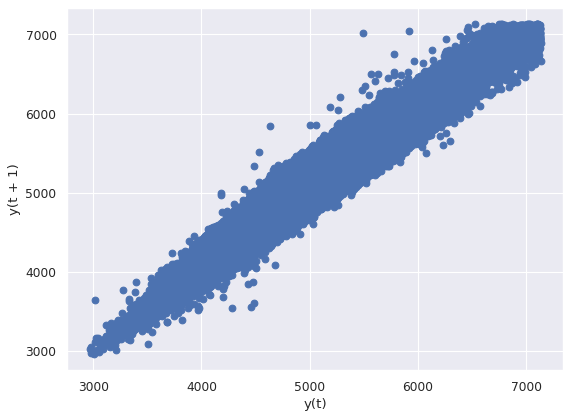

In [39]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)
pd.plotting.lag_plot(all_data_2[["consumption_MW"]], lag=1)

# Forecasting

## Non Stationary to Stationary Time Series
* In Time series the temporal structure adds an order to the observations. This imposed order means that important assumptions about the consistency of those observations needs to be handled specifically.
* For example, when modeling, there are assumptions that the summary statistics of observations are consistent. In time series terminology, we refer to this expectation as the time series being stationary. The observations in a stationary time series are not dependent on time.

In [41]:
series = targets.copy()
series= series.loc["2018-01":"2018-02"]
#series = series.resample('1440T').sum() #1140T = 60*24
#series["2017-11-26"] = series["2017-11-25"] 

### Naive Methods - ARIMA
* Navie method ARIMA is used to establish a baseline accuracy for our modelling
* using ARIMA data has to be stationary

In [ ]:
##!pip install git+https://github.com/statsmodels/statsmodels.git
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

#targets.index.freq = targets.index.inferred_freq
stlf = STLForecast(series, ARIMA, model_kwargs=dict(order=(1,1,0), trend="c"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(24)
plt.plot(series)
plt.plot(forecast)
plt.show()

### STL Decomposition
Seasonal-Trend decomposition using LOESS (STL) is a great to tool to provide insight into the Electrical consumption data. 


* For example, when modeling, there are assumptions that the summary statistics of observations are consistent. In time series terminology, we refer to this expectation as the time series being stationary. The observations in a stationary time series are not dependent on time.

* Time series that is non-stationary show seasonal effects, trends, and other structures that depend on the time index. Accurate modelling is very difficult in such a state so STL Decomposition was used to seperate out these components to make the data stationary.

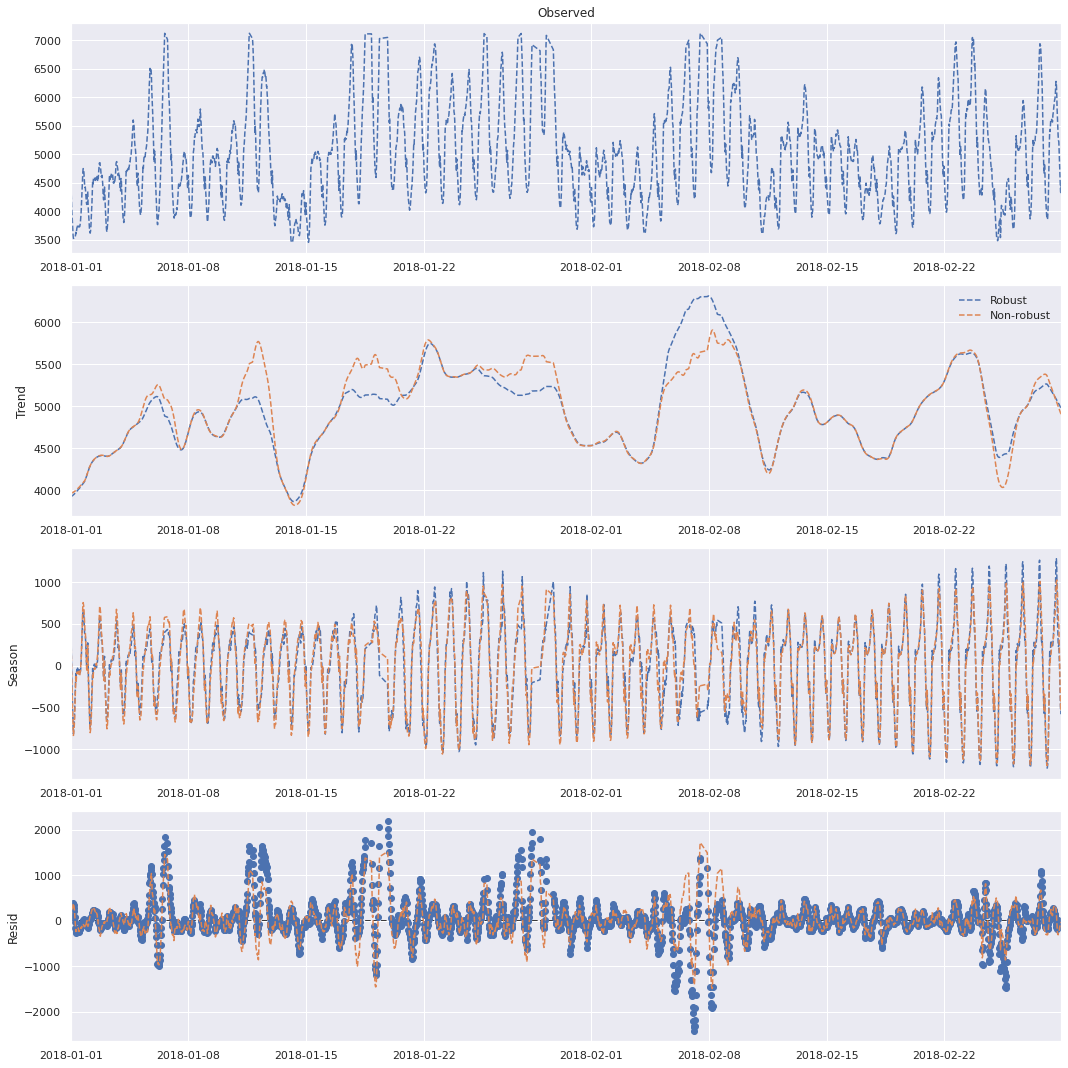

In [44]:
from statsmodels.tsa.seasonal import STL
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['lines.linestyle'] = '--'

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'residuals':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)
                
stl = STL(series, robust = True, seasonal=13, period=48)
res = stl.fit()
fig = res.plot()
res_non_robust = STL(series, seasonal=13, period=48, robust=False).fit()
add_stl_plot(fig, res_non_robust, ['Robust','Non-robust'])

* Looking at the total demand chart above the model looks more additive rather than multiplicative. 
* This appears to be the case given the very slight but linear changes to the trend over time. 
* Seasonality appears linear by maintaining a very consistent frequency and amplitude over the 4 years. 
* Thus the most approiate assumption when performing decompostion is that the models components are additive.

**Save residuals for training - stationary time series**
* These residuals will be our stationary time series for forecasting.
* Facebook Prophet forecasting model can use following residual data as target data when training